##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Forecasting with machine learning

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c05_forecasting_with_machine_learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c05_forecasting_with_machine_learning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [3]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

def trend(time, slope=0):
    return slope * time


def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))


def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)


def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

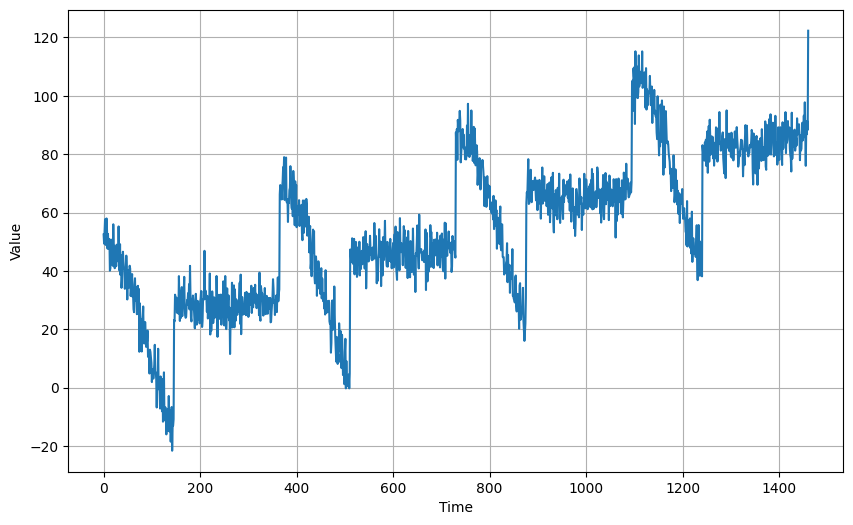

In [4]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

## Forecasting with Machine Learning

First, we will train a model to forecast the next step given the previous 30 steps, therefore, we need to create a dataset of 30-step windows for training.

In [5]:
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [6]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

### Linear Model

In [7]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
model.fit(train_set, epochs=100, validation_data=valid_set)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


     20/Unknown 1s 6ms/step - loss: 8.0369 - mae: 8.5260 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 8.0576 - mae: 8.5455 - val_loss: 7.4887 - val_mae: 7.9688
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.7431 - mae: 8.2294 - val_loss: 8.1737 - val_mae: 8.6589
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.0607 - mae: 8.5438 - val_loss: 7.8687 - val_mae: 8.3589
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.0347 - mae: 8.5233 - val_loss: 7.3098 - val_mae: 7.7882
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 7.5305 - mae: 8.0162 - val_loss: 7.7157 - val_mae: 8.2041
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.8054 - mae: 8.2915 - val_loss: 7.2174 - val_mae: 7.6998
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.6538 - mae: 8.1378 - val_loss: 7.1305 - val_mae: 7.6088
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 7.5565 - mae: 8.0406 - val_loss: 7.3604 - val_mae: 7.8465
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.3954 - mae: 

In [8]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 78.8033 - mae: 79.3033 - learning_rate: 1.0000e-06
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 64.3217 - mae: 64.8216 - learning_rate: 1.0798e-06
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 46.5433 - mae: 47.0432 - learning_rate: 1.1659e-06
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 27.3315 - mae: 27.8283 - learning_rate: 1.2589e-06
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 11.8240 - mae: 12.3164 - learning_rate: 1.3594e-06
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 10.6053 - mae: 11.0960 - learning_rate: 1.4678e-06
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 10.0439 - mae: 10.5260 - learning_rate: 1.5849e-06
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.3539 - mae: 10.8401 - learning_rate: 1.7113e-06
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.5254 - mae: 10.0091 - learning_rate: 1.8478e-06
Epoch 10/10

(np.float64(1e-06), np.float64(0.001), np.float64(0.0), np.float64(20.0))

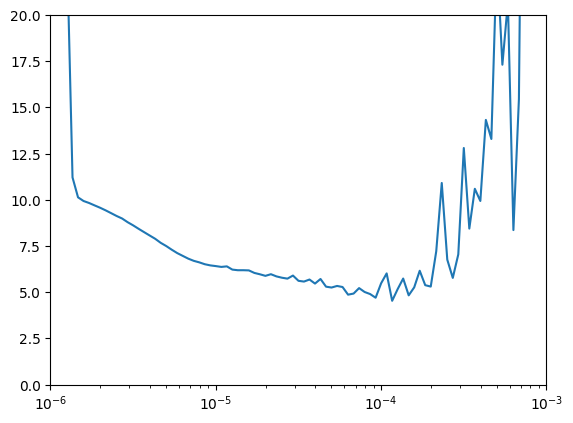

In [9]:
plt.semilogx(history.history["learning_rate"], history.history["loss"])
plt.axis([1e-6, 1e-3, 0, 20])

In [10]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 141.1415 - mae: 141.6405 - val_loss: 70.9813 - val_mae: 71.4813
Epoch 2/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 19.4209 - mae: 19.9165 - val_loss: 11.2180 - val_mae: 11.7128
Epoch 3/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.2835 - mae: 7.7657 - val_loss: 6.7625 - val_mae: 7.2527
Epoch 4/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.7419 - mae: 7.2228 - val_loss: 6.7916 - val_mae: 7.2743
Epoch 5/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.5740 - mae: 7.0558 - val_loss: 6.6543 - val_mae: 7.1435
Epoch 6/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.5685 - mae: 7.0542 - val_loss: 6.6320 - val_mae: 7.1147
Epoch 7/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.5366 - mae: 7.0154 - val_loss: 6.6008 - val_mae: 7.0821
Epoch 8/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 6.5067 - mae: 6.9926 - val_loss: 6.5753 - val_mae: 7.0652
Epoch 9/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

In [11]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [12]:
lin_forecast = model_forecast(model, series[split_time - window_size:-1], window_size)[:, 0]

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [13]:
lin_forecast.shape

(461,)

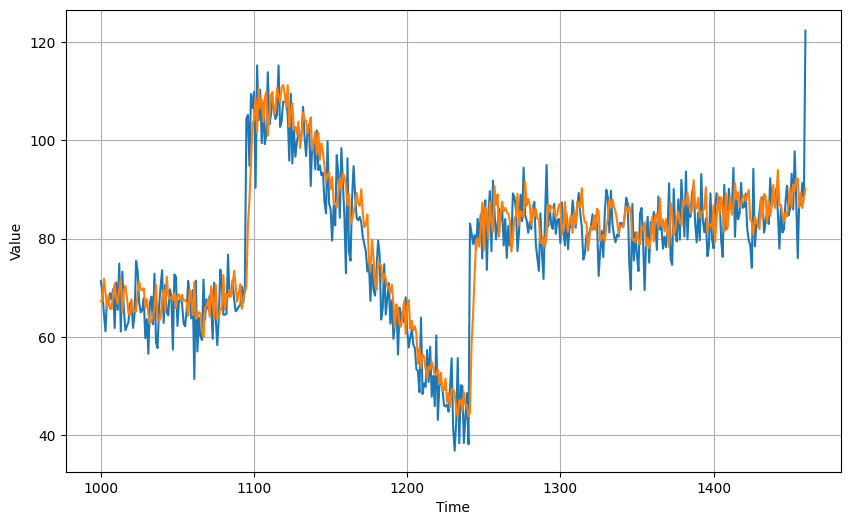

In [14]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, lin_forecast)

In [15]:
keras.metrics.mae(x_valid, lin_forecast).numpy()

np.float32(5.1924934)

### Dense Model Forecasting

In [16]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 43.4936 - mae: 43.9931 - learning_rate: 1.0000e-07
Epoch 2/100
25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 41.3704 - mae: 41.8703  

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 41.2726 - mae: 41.7725 - learning_rate: 1.1220e-07
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 39.5958 - mae: 40.0953 - learning_rate: 1.2589e-07
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 37.3592 - mae: 37.8580 - learning_rate: 1.4125e-07
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 35.1399 - mae: 35.6398 - learning_rate: 1.5849e-07
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 32.6165 - mae: 33.1155 - learning_rate: 1.7783e-07
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 30.1145 - mae: 30.6140 - learning_rate: 1.9953e-07
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 27.5067 - mae: 28.0061 - learning_rate: 2.2387e-07
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 24.4634 - mae: 24.9625 - learning_rate: 2.5119e-07
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21.7891 - mae: 22.2877 - learning_rate: 2.8184e-07
Epoch 11/100
31/31 ━━

(np.float64(1e-07), np.float64(0.005), np.float64(0.0), np.float64(30.0))

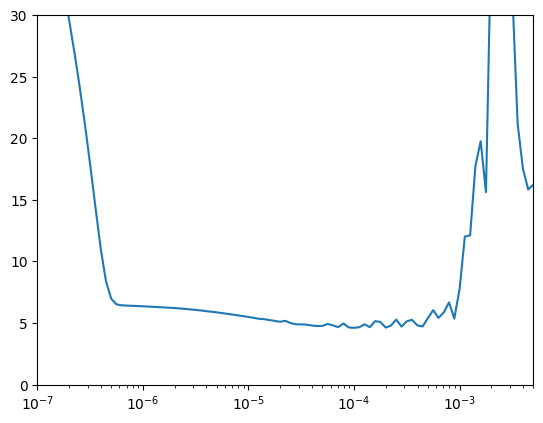

In [17]:
plt.semilogx(history.history["learning_rate"], history.history["loss"])
plt.axis([1e-7, 5e-3, 0, 30])

In [18]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

optimizer = keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 47.8686 - mae: 48.3684 - val_loss: 31.9319 - val_mae: 32.4319
Epoch 2/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 12.4270 - mae: 12.9154 - val_loss: 8.1337 - val_mae: 8.6206
Epoch 3/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.2026 - mae: 8.6842 - val_loss: 7.3561 - val_mae: 7.8392
Epoch 4/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.6375 - mae: 8.1155 - val_loss: 6.9541 - val_mae: 7.4406
Epoch 5/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.8707 - mae: 7.3524 - val_loss: 6.8875 - val_mae: 7.3665
Epoch 6/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.9886 - mae: 7.4682 - val_loss: 6.6110 - val_mae: 7.0951
Epoch 7/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.0890 - mae: 7.5703 - val_loss: 6.5728 - val_mae: 7.0569
Epoch 8/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.0011 - mae: 7.4792 - val_loss: 6.4581 - val_mae: 6.9433
Epoch 9/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss

In [19]:
dense_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


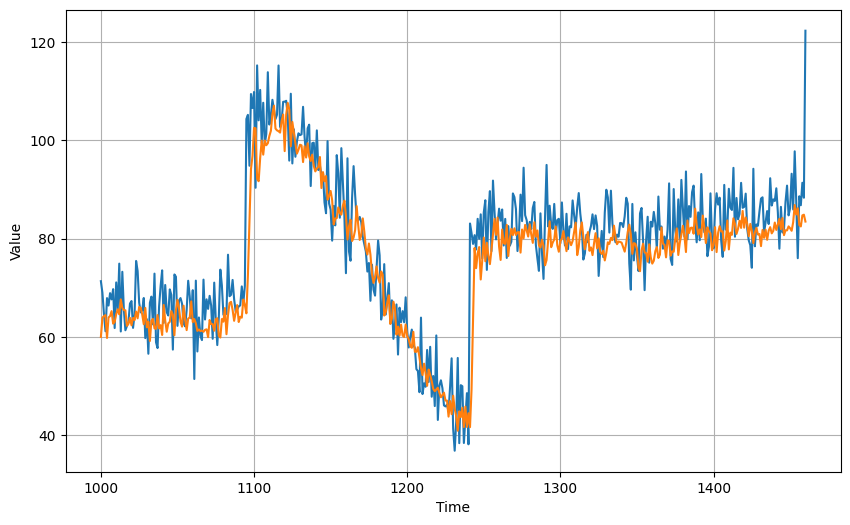

In [20]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, dense_forecast)

In [21]:
keras.metrics.mae(x_valid, dense_forecast).numpy()

np.float32(5.4120517)